In [1]:
import gurobi as gp
from gurobi import GRB
import numpy as np
import matplotlib.pyplot as plt

Consider the following convex constrained optimization problem:
$$
\min f(x)=x_1^2 + 2x_2^2
$$
subject to
$$
\begin{aligned}
x_1 + x_2 &= 3 \\
\end{aligned}
$$
This file tries to use the Lagrangian multiplier method, augmented Lagrangian multiplier method, and ADMM to solve the problem.

In [2]:
# Use Gurobi to solve the following problem
model = gp.Model()
x1 = model.addVar(lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x1")
x2 = model.addVar(lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x2")
model.setObjective(x1**2 + 2*x2**2, GRB.MINIMIZE)
model.addConstr(x1 + x2 == 3)
model.setParam("OutputFlag", 0)
model.optimize()
print("x1 = ", x1.x)
print("x2 = ", x2.x)
print("obj = ", model.objVal)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-25
x1 =  1.9999999994655229
x2 =  1.000000000534477
obj =  5.999999999999999


# 1. Lagrangian multiplier method
The Lagrangian function is:
$$
L(x,\lambda) = x_1^2 + 2x_2^2 + \lambda (x_1 + x_2 - 3)
$$
where $\lambda$ is the Lagrangian multiplier. At the optimal point, the gradient of the Lagrangian function is zero:
$$
\nabla L(x,\lambda) = 
\begin{bmatrix}
\nabla_{x_1} L(x,\lambda) \\
\nabla_{x_2} L(x,\lambda) \\
\nabla_{\lambda} L(x,\lambda) 
\end{bmatrix}
=
\begin{bmatrix}
2x_1 + \lambda \\
4x_2 + \lambda \\
x_1 + x_2 - 3
\end{bmatrix} = 0
$$

The dual function is:
$$
g(\lambda) = \inf_{x} L(x,\lambda) = \inf_{x} (x_1^2 + 2x_2^2 + \lambda (x_1 + x_2 - 3))
$$

The dual problem is:
$$
\max g(\lambda)
$$

The Lagrangian multiplier method is to solve the dual problem. The dual problem is a concave optimization problem, so we can use the gradient ascent method to solve it.

- Step 1: Initialize $\lambda^0 = 0$.
- Step 2: Find the minimizer of $L(x,\lambda^k)$, i.e., $x^k = \arg\min_{x} L(x,\lambda_k)$. This step is actually evaluating the dual function $g(\lambda)$ at $\lambda^k$.
- Step 3: Update $\lambda^{k+1} = \lambda^k + \alpha_k \nabla_{\lambda} L(x^k,\lambda^k)$, where $\alpha_k$ is the step size. This step is actually updating $\lambda^k$ using the gradient ascent method, i.e., $\lambda^{k+1} = \lambda^k + \alpha_k \nabla g(\lambda^k)$.
- Step 4: Repeat Step 2 and Step 3 until convergence.

In [3]:
# functions
def obj_func(x1, x2):
    """
    Objective function.
    """
    return x1**2 + 2*x2**2

def primal_residual(x1, x2):
    """
    primal residual.
    """
    return x1 + x2 - 3

def Lagrangian(x1, x2, lam):
    """
    Lagrangian function.
    """
    return x1**2 + 2*x2**2 + lam*(x1 + x2 - 3)

def dLdx1(x1, x2, lam):
    """
    Derivative of Lagrangian function with respect to x1.
    """
    return 2*x1 + lam

def dLdx2(x1, x2, lam):
    """
    Derivative of Lagrangian function with respect to x2.
    """
    return 4*x2 + lam

def dLdlam(x1, x2, lam):
    """
    Derivative of Lagrangian function with respect to lambda.
    """
    return x1 + x2 - 3

def min_x1_x2(lam):
    """
    Given lambda, return the optimal x1 and x2.
    """
    x1 = -lam/2
    x2 = -lam/4
    return x1, x2

def dual_func(lam):
    """
    Dual function.
    """
    x1, x2 = min_x1_x2(lam)
    return obj_func(x1, x2)

def LM(x1, x2, lam, alpha=0.1, max_iter=100):
    """
    Lagrangian Multiplier method.
    """
    for i in range(max_iter):
        x1, x2 = min_x1_x2(lam)
        lam = lam + alpha * dLdlam(x1, x2, lam) # use MSA to update lambda
        print(f"iter = {i}, x1 = {x1:e}, x2 = {x2:e}, lam = {lam:e}, LB = {dual_func(lam):e}, p_res={primal_residual(x1, x2):e}")

In [4]:
# Method of Lagrange multipliers
# Initialize
x1 = 0
x2 = 0
lam = 0
# Iteration
LM(x1, x2, lam, alpha=0.1, max_iter=100)

iter = 0, x1 = 0.000000e+00, x2 = 0.000000e+00, lam = -3.000000e-01, LB = 3.375000e-02, p_res=-3.000000e+00
iter = 1, x1 = 1.500000e-01, x2 = 7.500000e-02, lam = -5.775000e-01, LB = 1.250648e-01, p_res=-2.775000e+00
iter = 2, x1 = 2.887500e-01, x2 = 1.443750e-01, lam = -8.341875e-01, LB = 2.609508e-01, p_res=-2.566875e+00
iter = 3, x1 = 4.170938e-01, x2 = 2.085469e-01, lam = -1.071623e+00, LB = 4.306413e-01, p_res=-2.374359e+00
iter = 4, x1 = 5.358117e-01, x2 = 2.679059e-01, lam = -1.291252e+00, LB = 6.252491e-01, p_res=-2.196282e+00
iter = 5, x1 = 6.456258e-01, x2 = 3.228129e-01, lam = -1.494408e+00, LB = 8.374705e-01, p_res=-2.031561e+00
iter = 6, x1 = 7.472039e-01, x2 = 3.736020e-01, lam = -1.682327e+00, LB = 1.061334e+00, p_res=-1.879194e+00
iter = 7, x1 = 8.411636e-01, x2 = 4.205818e-01, lam = -1.856153e+00, LB = 1.291989e+00, p_res=-1.738255e+00
iter = 8, x1 = 9.280763e-01, x2 = 4.640382e-01, lam = -2.016941e+00, LB = 1.525519e+00, p_res=-1.607885e+00
iter = 9, x1 = 1.008471e+00,

# 2. Augmented Lagrangian multiplier method

The augmented Lagrangian function is:
$$
L_{\rho}(x,\lambda) = x_1^2 + 2x_2^2 + \lambda (x_1 + x_2 - 3) + \frac{\rho}{2} (x_1 + x_2 - 3)^2
$$
where $\lambda$ is the Lagrangian multiplier and $\rho$ is the penalty parameter. At the optimal point, the gradient of the augmented Lagrangian function is zero:
$$
\nabla L_{\rho}(x,\lambda) =
\begin{bmatrix}
\nabla_{x_1} L_{\rho}(x,\lambda) \\
\nabla_{x_2} L_{\rho}(x,\lambda) \\
\nabla_{\lambda} L_{\rho}(x,\lambda)
\end{bmatrix}
=
\begin{bmatrix}
2x_1 + \lambda + \rho (x_1 + x_2 - 3) \\
4x_2 + \lambda + \rho (x_1 + x_2 - 3) \\
x_1 + x_2 - 3
\end{bmatrix} = 0
$$

The steps of the augmented Lagrangian multiplier method:
- Step 1: Initialize $\lambda^0 = 0$, $\rho_0 = 1$, and $\eta>1$.
- Step 2: Find the minimizer of $L_{\rho_k}(x,\lambda^k)$, i.e., $x^k = \arg\min_{x} L_{\rho_k}(x,\lambda^k)$.
- Step 3: Update $\lambda^{k+1} = \lambda^k + \rho_k \nabla_{\lambda} L_{\rho_k}(x^k,\lambda^k)$.
- Step 4: Update $\rho_{k+1} = \rho_k \times \eta$.
- Step 5: Repeat Step 2 to Step 4 until convergence.

For this problem, Step 2 is actually solving the following system of equations:
$$
\begin{bmatrix}
2 + \rho_k & \rho_k \\
\rho_k & 4 + \rho_k
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
3\rho_k -\lambda_k  \\
3\rho_k -\lambda_k
\end{bmatrix}
$$

In [5]:
def augmented_Lagrangian(x1, x2, lam, rho):
    """
    Augmented Lagrangian function.
    """
    return x1**2 + 2*x2**2 + lam*(x1 + x2 - 3) + rho/2*(x1 + x2 - 3)**2

def dALdx1(x1, x2, lam, rho):
    """
    Derivative of augmented Lagrangian function with respect to x1.
    """
    return 2*x1 + lam + rho*(x1 + x2 - 3)

def dALdx2(x1, x2, lam, rho):
    """
    Derivative of augmented Lagrangian function with respect to x2.
    """
    return 4*x2 + lam + rho*(x1 + x2 - 3)

def dALdlam(x1, x2, lam, rho):
    """
    Derivative of augmented Lagrangian function with respect to lambda.
    """
    return x1 + x2 - 3

def min_x1_x2_AL(lam, rho):
    """
    Given lambda and rho, return the optimal x1 and x2.
    """
    A = np.array([[2 + rho, rho], 
                  [rho, 4 + rho]])
    b = np.array([3*rho - lam, 
                  3*rho - lam])
    x1, x2 = np.linalg.solve(A, b)
    return x1, x2

def ALM(x1, x2, lam, rho, eta, max_iter):
    """
    ALM.
    """
    for i in range(max_iter):
        x1, x2 = min_x1_x2_AL(lam, rho)
        lam = lam + rho * primal_residual(x1, x2)
        rho = rho * eta
        print(f"iter = {i}, x1 = {x1:e}, x2 = {x2:e}, lam = {lam:e}, LB = {augmented_Lagrangian(x1, x2, lam, rho):e}, primal_residual={primal_residual(x1, x2):e}")

In [6]:
# Augmented Lagrangian method
# Initialize
x1 = 0
x2 = 0
lam = 0
rho = 1
eta = 1.1
# Iteration
ALM(x1, x2, lam, rho, eta, 30)

iter = 0, x1 = 8.571429e-01, x2 = 4.285714e-01, lam = -1.714286e+00, LB = 5.657143e+00, primal_residual=-1.714286e+00
iter = 1, x1 = 1.373777e+00, x2 = 6.868885e-01, lam = -2.747554e+00, LB = 5.945588e+00, primal_residual=-9.393346e-01
iter = 2, x1 = 1.671705e+00, x2 = 8.358524e-01, lam = -3.343410e+00, LB = 5.999717e+00, primal_residual=-4.924428e-01
iter = 3, x1 = 1.835709e+00, x2 = 9.178543e-01, lam = -3.671417e+00, LB = 6.003971e+00, primal_residual=-2.464370e-01
iter = 4, x1 = 1.921694e+00, x2 = 9.608471e-01, lam = -3.843388e+00, LB = 6.001912e+00, primal_residual=-1.174586e-01
iter = 5, x1 = 1.964534e+00, x2 = 9.822668e-01, lam = -3.929067e+00, LB = 6.000620e+00, primal_residual=-5.319968e-02
iter = 6, x1 = 1.984770e+00, x2 = 9.923848e-01, lam = -3.969539e+00, LB = 6.000161e+00, primal_residual=-2.284551e-02
iter = 7, x1 = 1.993813e+00, x2 = 9.969063e-01, lam = -3.987625e+00, LB = 6.000035e+00, primal_residual=-9.280992e-03
iter = 8, x1 = 1.997627e+00, x2 = 9.988136e-01, lam = -3

# 3. ADMM

In the augmented Lagrangian multiplier method, Step 2 can still be hard to solve when dealing with large-scale problems. 
- Step 2: Find the minimizer of $L_{\rho_k}(x,\lambda^k)$, i.e., $x^k = \arg\min_{x} L_{\rho_k}(x,\lambda^k)$.

The ADMM method further utilizes the block coordinate descent method to solve Step 2. Assuming that the variables can be partitioned into two blocks as in this file, then Step 2 can be divided into two subproblems:
$$
\begin{aligned}
x_1^{k+1} &= \arg\min_{x_1} L_{\rho_k}(x_1,x_2^k,\lambda^k) \\
x_2^{k+1} &= \arg\min_{x_2} L_{\rho_k}(x_1^{k+1},x_2,\lambda^k)
\end{aligned}
$$

The detailed steps of ADMM are as follows:
- Step 1: Initialize $\lambda^0 = 0$, $\rho_0 = 1$, and $\eta>1$.
- Step 2: Find the minimizer of $L_{\rho_k}(x_1,x_2^k,\lambda^k)$, i.e., $x_1^{k+1} = \arg\min_{x_1} L_{\rho_k}(x_1,x_2^k,\lambda^k)$.
- Step 3: Find the minimizer of $L_{\rho_k}(x_1^{k+1},x_2,\lambda^k)$, i.e., $x_2^{k+1} = \arg\min_{x_2} L_{\rho_k}(x_1^{k+1},x_2,\lambda^k)$.
- Step 4: Update $\lambda^{k+1} = \lambda^k + \rho_k \nabla_{\lambda} L_{\rho_k}(x^k, \lambda^k)$.
- Step 5: Repeat Step 2 to Step 4 until convergence.

In [7]:
def min_x1_AL(x2, lam, rho):
    """
    Given x2, lambda, and rho, return the optimal x1.
    """
    return (3*rho - lam - rho*x2)/(2 + rho)

def min_x2_AL(x1, lam, rho):
    """
    Given x1, lambda, and rho, return the optimal x2.
    """
    return (3*rho - lam - rho*x1)/(4 + rho)

def ADMM(x1, x2, lam, rho, max_iter, log=True):
    """
    ADMM method.
    """
    for i in range(max_iter):
        x1 = min_x1_AL(x2, lam, rho)
        x2 = min_x2_AL(x1, lam, rho)
        lam = lam + rho * primal_residual(x1, x2)
        if log:
            print(f"iter = {i}, x1 = {x1:e}, x2 = {x2:e}, lam = {lam:e}, LB = {dual_func(lam):e}, primal_residual={primal_residual(x1, x2):e}")
    return x1, x2, lam, obj_func(x1, x2), primal_residual(x1, x2)

In [8]:
# Alternating direction method of multipliers (ADMM)
# Initialize
x1 = 0
x2 = 0
lam = 0
rho = 1
ADMM(x1, x2, lam, rho=1, max_iter=30)

iter = 0, x1 = 1.000000e+00, x2 = 4.000000e-01, lam = -1.600000e+00, LB = 9.600000e-01, primal_residual=-1.600000e+00
iter = 1, x1 = 1.400000e+00, x2 = 6.400000e-01, lam = -2.560000e+00, LB = 2.457600e+00, primal_residual=-9.600000e-01
iter = 2, x1 = 1.640000e+00, x2 = 7.840000e-01, lam = -3.136000e+00, LB = 3.687936e+00, primal_residual=-5.760000e-01
iter = 3, x1 = 1.784000e+00, x2 = 8.704000e-01, lam = -3.481600e+00, LB = 4.545577e+00, primal_residual=-3.456000e-01
iter = 4, x1 = 1.870400e+00, x2 = 9.222400e-01, lam = -3.688960e+00, LB = 5.103160e+00, primal_residual=-2.073600e-01
iter = 5, x1 = 1.922240e+00, x2 = 9.533440e-01, lam = -3.813376e+00, LB = 5.453189e+00, primal_residual=-1.244160e-01
iter = 6, x1 = 1.953344e+00, x2 = 9.720064e-01, lam = -3.888026e+00, LB = 5.668779e+00, primal_residual=-7.464960e-02
iter = 7, x1 = 1.972006e+00, x2 = 9.832038e-01, lam = -3.932815e+00, LB = 5.800139e+00, primal_residual=-4.478976e-02
iter = 8, x1 = 1.983204e+00, x2 = 9.899223e-01, lam = -3

(1.9999996315434672,
 0.9999997789260803,
 -3.999999115704321,
 5.999997641878423,
 -5.895304524550227e-07)

Text(0, 0.5, '$\\log_{10}$(abs(primal residual))')

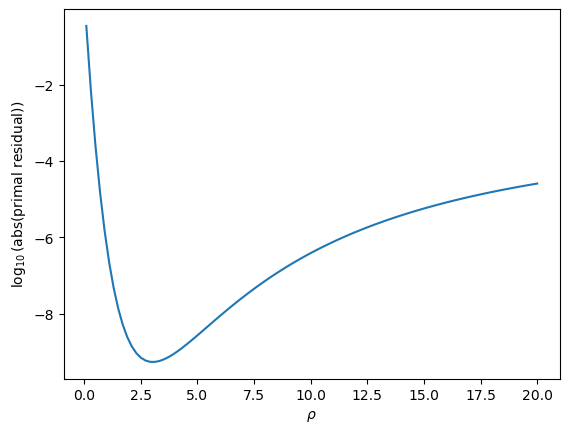

In [9]:
# the choice of rho is important for the convergence of ADMM
rhos = np.linspace(0.1, 20, 100)
primal_residuals = []
for rho in rhos:
    x1 = 0
    x2 = 0
    lam = 0
    x1, x2, lam, obj, res = ADMM(x1, x2, lam, rho, max_iter=30, log=False)
    primal_residuals.append(abs(res))
# plot log primal residual vs. rho
plt.plot(rhos, np.log10(primal_residuals))
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\log_{10}$(abs(primal residual))")

Compared to the augmented Lagrangian multiplier method, the ADMM method has the following advantages:
- It divides the original problem into subproblems, which is easier to solve and can be implemented in a parallel fasion (can we use Jacobian method?).
- Although the choice of $\rho$ will affect the convergence rate, it is easier to implement than the ALM method since it does not require the choice of $\eta$.

In [10]:
# the choice of rho and eta
ALM(x1=0, x2=0, lam=0, rho=1, eta=3, max_iter=40)

iter = 0, x1 = 8.571429e-01, x2 = 4.285714e-01, lam = -1.714286e+00, LB = 8.448980e+00, primal_residual=-1.714286e+00
iter = 1, x1 = 1.648352e+00, x2 = 8.241758e-01, lam = -3.296703e+00, LB = 7.066538e+00, primal_residual=-5.274725e-01
iter = 2, x1 = 1.954626e+00, x2 = 9.773130e-01, lam = -3.909252e+00, LB = 6.059448e+00, primal_residual=-6.806097e-02
iter = 3, x1 = 1.997865e+00, x2 = 9.989324e-01, lam = -3.995730e+00, LB = 6.000409e+00, primal_residual=-3.202869e-03
iter = 4, x1 = 1.999965e+00, x2 = 9.999827e-01, lam = -3.999931e+00, LB = 6.000000e+00, primal_residual=-5.186833e-05
iter = 5, x1 = 2.000000e+00, x2 = 9.999999e-01, lam = -4.000000e+00, LB = 6.000000e+00, primal_residual=-2.830468e-07
iter = 6, x1 = 2.000000e+00, x2 = 1.000000e+00, lam = -4.000000e+00, LB = 6.000000e+00, primal_residual=-5.167449e-10
iter = 7, x1 = 2.000000e+00, x2 = 1.000000e+00, lam = -4.000000e+00, LB = 6.000000e+00, primal_residual=-3.144152e-13
iter = 8, x1 = 2.000000e+00, x2 = 1.000000e+00, lam = -4

LinAlgError: Singular matrix